In [2]:
import pandas as pd
import numpy as np
import data_frame
import tensorflow as tf
from data_frame import DataFrame, MaxFiller
import xgboost as xgb
from metrics import redshift_error
from sklearn.metrics import mean_squared_error, r2_score

import importlib

In [3]:
filePath = "../KiDS-DR5-WCScut_x_DESI-DR1-small.fits"

In [14]:
importlib.reload(data_frame)
df = DataFrame(filePath, "QSO", filler=MaxFiller())
df.data = df.data.dropna()
X_train, y_train = df.data[df.features], df.data["Z"]
df = df.data[df.features + ["Z"]]

In [15]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [37]:
def evaluate():
    pass

In [16]:
y_pred = model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
redshift_err = redshift_error(y_train, y_pred)
print(f"MSE: {mse:.2f}")
print(f"R^2: {r2*100:.0f}%")
print(f"Redshift error: {redshift_err[0]:.2f} +/- {redshift_err[1]:.2f}")

MSE: 0.09
R^2: 84%
Redshift error: 0.01 +/- 0.13


In [11]:
X_train["MAG_GAAP_r"].max()

np.float32(25.945515)

In [17]:
df['MAG_bin'] = pd.cut(df['MAG_GAAP_r'], bins=np.arange(15.38, 25.96, 0.1), include_lowest=True)

In [18]:
mse_per_bin = {}
r2_per_bin = {}
redshift_err_per_bin = {}


for bin_label, group in df.groupby('MAG_bin'):
    if len(group) < 2:
        continue  # skip tiny bins that can't give meaningful R²

    X_bin = group.drop(columns=['Z', 'MAG_bin'])  # Adjust if your target column is named differently
    y_bin = group['Z']

    y_pred = model.predict(X_bin)
    r2 = r2_score(y_bin, y_pred)
    r2_per_bin[str(bin_label)] = r2
    mse = mean_squared_error(y_bin, y_pred)
    mse_per_bin[str(bin_label)] = mse
    redshift_err = redshift_error(y_bin, y_pred)
    redshift_err_per_bin[str(bin_label)] = redshift_err[0]
    

/tmp/ipykernel_715232/626316354.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin_label, group in df.groupby('MAG_bin'):


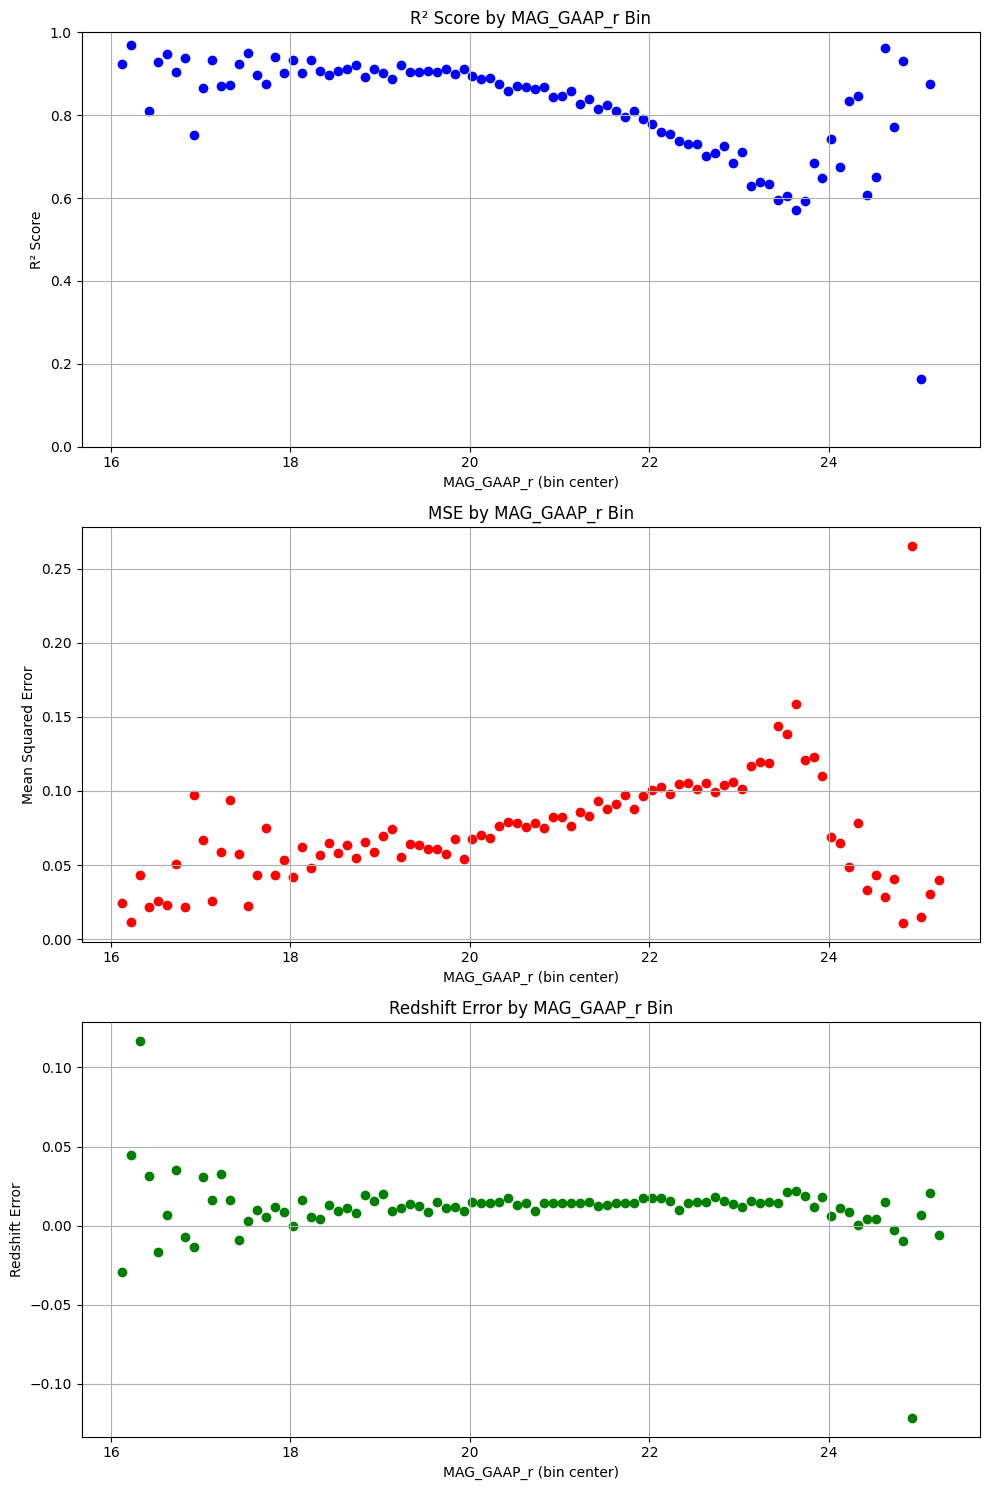

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare DataFrame as before
metrics_df = pd.DataFrame({
    'MAG_bin': list(r2_per_bin.keys()),
    'R2': list(r2_per_bin.values()),
    'MSE': list(mse_per_bin.values()),
    'Redshift_Error': list(redshift_err_per_bin.values())
})

def bin_center(interval_str):
    left, right = interval_str.strip('()[]').split(',')
    return (float(left) + float(right)) / 2

metrics_df['bin_center'] = metrics_df['MAG_bin'].apply(bin_center)
metrics_df = metrics_df.sort_values('bin_center')

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot R²
axs[0].scatter(metrics_df['bin_center'], metrics_df['R2'], color='blue')
axs[0].set_ylim(0,1)
axs[0].set_xlabel('MAG_GAAP_r (bin center)')
axs[0].set_ylabel('R² Score')
axs[0].set_title('R² Score by MAG_GAAP_r Bin')
axs[0].grid(True)

# Plot MSE
axs[1].scatter(metrics_df['bin_center'], metrics_df['MSE'], color='red')
axs[1].set_xlabel('MAG_GAAP_r (bin center)')
axs[1].set_ylabel('Mean Squared Error')
axs[1].set_title('MSE by MAG_GAAP_r Bin')
axs[1].grid(True)

# Plot Redshift Error
axs[2].scatter(metrics_df['bin_center'], metrics_df['Redshift_Error'], color='green')
axs[2].set_xlabel('MAG_GAAP_r (bin center)')
axs[2].set_ylabel('Redshift Error')
axs[2].set_title('Redshift Error by MAG_GAAP_r Bin')
axs[2].grid(True)

plt.tight_layout()
plt.show()